In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn.metrics as sm
import seaborn as sns
import re
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [117]:
df = pd.read_csv('../website_classification.csv')
df.head(5)

,website_url,cleaned_website_text,Category
0,https://www.thefulltoss.com/,toss cricket blog english cricket spin irrever...,News
1,https://secondlife.com/,official site second life virtual world virtua...,Social Networking and Messaging
2,https://www.paltalk.com/,video chat paltalk large video chat room commu...,Social Networking and Messaging
3,https://secure.imvu.com/welcome/ftux/,imvu 3d avatar social app virtual world virtua...,Social Networking and Messaging
4,https://enterchatroom.com/,enter chatroom free online chat room free chat...,Social Networking and Messaging


In [118]:
df.info() #checking if there is any Nan or null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   website_url           1013 non-null   object
 1   cleaned_website_text  1013 non-null   object
 2   Category              1013 non-null   object
dtypes: object(3)
memory usage: 23.9+ KB


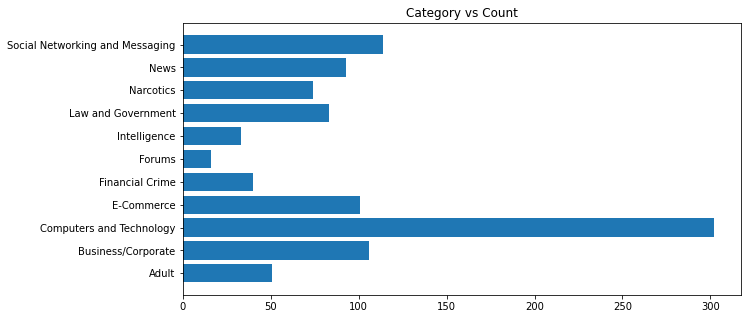

In [119]:
#visualising the count of each category
plt.figure(figsize=(10,5))
plt.title("Category vs Count")
site_category_count = pd.DataFrame(df.groupby(df['Category']).size(),columns=['Count'])
plt.barh(width=site_category_count['Count'],y=site_category_count.index)
plt.show()

In [120]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'
    
#Define function to lemmatize each word with its POS tag
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    pos_tagged_text = [(word, pos_tagger(pos_tag)) for word, pos_tag in pos_tagged_text]
    return [lem.lemmatize(word, pos_tag) for word, pos_tag in pos_tagged_text]

In [121]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(["decemeber","dec","january","jan","feb","february","march","mar","may","april","apr","june","jun","july","jul","august","aug","september","sept","oct","october","nov","november",
                   "one","two","three","hundred","thousand","million","billion","today","tomorow","week","month","year","sign in","login","sign up"])

df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: x.lower())
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'http\S+|www\S+', ' ', x))
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'_+',' ',x))
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'\d+','',x))
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'\s+',' ',x))
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: word_tokenize(x))
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: [word for word in x if word not in stop_words])
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: [word for word in x if len(word)>3])
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: lemmatize_words(x))
# df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: [lem.lemmatize(word) for word in x])
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: ' '.join(x))

In [122]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

In [123]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['cleaned_website_text'],df['Category'],test_size=0.2,random_state=42)

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_id_vectorizer = TfidfVectorizer(analyzer='word',smooth_idf=True,max_features=5000)
tf_id_train = tf_id_vectorizer.fit_transform(X_train)
tf_id_test = tf_id_vectorizer.transform(X_test)

In [103]:
# feature_frequencies = tf_id_train.sum(axis=0)
# feature_frequencies_1d = np.ravel(feature_frequencies)
# threshold_frequency = np.percentile(feature_frequencies_1d, 50)
# low_frequency_features = [feature for feature,frequency in zip(tf_id_vectorizer.get_feature_names_out(),feature_frequencies.A1) if frequency < threshold_frequency]

In [104]:
# vectorizer_filtered = TfidfVectorizer(analyzer='word',smooth_idf=True, max_features=5000, vocabulary=set(tf_id_vectorizer.get_feature_names_out())-set(low_frequency_features),ngram_range=(1,2))
# tf_id_train_filtered = vectorizer_filtered.fit_transform(X_train)
# tf_id_test_filtered = vectorizer_filtered.transform(X_test)

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have your training data (X_train) and corresponding labels (y_train)

# Define the models and their respective hyperparameters to try during grid search
models = {
    'MNB': {
        'model': MultinomialNB(),
        'params': {
            'mnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'svm__C': [1, 10],
            'svm__kernel': ['linear', 'rbf']
        }
    },
}

# Perform grid search and cross-validation for each model
for model_name, model_data in models.items():
    print("Evaluating:", model_name)
    
    # Create a pipeline with a TF-IDF vectorizer and the current model
    pipeline = Pipeline([
        ("feature_selection", SelectKBest(score_func=chi2)),
        (model_name.lower(), model_data['model'])
    ])
    
    # Define the hyperparameters for the current model
    parameters = {
        'feature_selection__k':[1000, 2000, 3000, 4000, 5000],
        **model_data['params']
    }
    
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
    grid_search.fit(tf_id_train, y_train)
    
    # Get the best model and its corresponding hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions on the test set
    y_pred = best_model.predict(tf_id_test)
    
    # Calculate and print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted',zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted',zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted',zero_division=0)
    
    print("Best parameters:", best_params)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print("----------------------------------")

Evaluating: MNB
Best parameters: {'feature_selection__k': 5000, 'mnb__alpha': 0.1}
Accuracy: 0.8916256157635468
Precision: 0.8805295257849056
Recall: 0.8916256157635468
F1 score: 0.8798405257195155
----------------------------------
Evaluating: SVM
Best parameters: {'feature_selection__k': 4000, 'svm__C': 10, 'svm__kernel': 'linear'}
Accuracy: 0.9014778325123153
Precision: 0.9093979200875753
Recall: 0.9014778325123153
F1 score: 0.8969034691375939
----------------------------------


In [126]:
from sklearn.feature_selection import chi2
k = 4000
chi2_selector = SelectKBest(score_func=chi2, k=k)

X_train_selected = chi2_selector.fit_transform(tf_id_train, y_train)
X_test_selected = chi2_selector.transform(tf_id_test)

In [127]:
# model = MultinomialNB(alpha=0.1)
model = SVC(C=10, kernel='linear')
model.fit(X_train_selected,y_train)

SVC(C=10, kernel='linear')

In [128]:
import sklearn.metrics as sm

y_pred = model.predict(X_test_selected)
print(f'The accuracy of train model is {sm.accuracy_score(y_train,model.predict(X_train_selected))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 0.9987654320987654
The accuracy of test model is 0.9014778325123153


              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.88      0.96      0.92        24
           2       0.98      0.83      0.90        75
           3       0.96      1.00      0.98        26
           4       0.70      1.00      0.82         7
           5       0.25      1.00      0.40         1
           6       0.80      1.00      0.89         4
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        13
          10       0.68      0.72      0.70        18

    accuracy                           0.90       203
   macro avg       0.82      0.95      0.86       203
weighted avg       0.92      0.90      0.91       203



<AxesSubplot:>

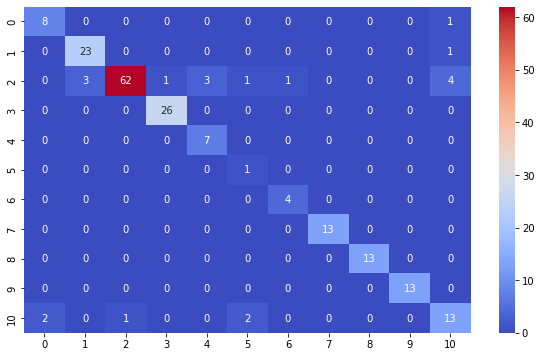

In [129]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

plt.figure(figsize=(10,6))
predictions = model.predict(X_test_selected)
print(classification_report(predictions,y_test))
sns.heatmap(confusion_matrix(predictions,y_test),cmap='coolwarm',annot=True)

In [130]:
pd.set_option('display.max_rows', None)
predictions = model.predict(X_test_selected)
results = pd.DataFrame({'Cleaned Text':tf_id_test,'Actual':y_test,'Predicted':predictions})
df.iloc[results[(results['Actual']==4) & (results['Actual']!=results['Predicted'])].index]["website_url"]

967    https://carding.store/classifieds/item/6-cardi...
968    https://carding.store/classifieds/item/29-5-cv...
969    https://carding.store/classifieds/item/28-the-...
Name: website_url, dtype: object

In [131]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os


class ScrapTool:   
    def visit_url(self,website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #Set up Selenium webdriver
        PATH = 'C:/Users/User01/Downloads/chromedriver_win32/chromedriver.exe'

        # Set the Chrome webdriver options
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        # Initialize the Chrome webdriver and pass the Chrome options
        service = Service(PATH)
        driver = webdriver.Chrome(service = service, options = chrome_options)

        #Load website
        driver.get(website_url)
        
        # Check if the cookie consent button is present
        cookie_button = None
        try:
            cookie_button = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "cookie-consent-button")))
        except:
            pass

        # Handle cookies if the button is present
        if cookie_button:
            cookie_button.click()

        # Extract HTML content
        html_content = driver.page_source
        driver.quit()

        soup = BeautifulSoup(html_content,'lxml')
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                    self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(string=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

In [132]:
#cleaning text and preprocessing
def cleaning_text(text):
    text = text.lower()
    # text = re.sub(r'http\S+',' ',text)
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub(r'_+',' ',text)
    text = re.sub(r'\d+','',text)
    text = re.sub(r'\s+',' ',text)   
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    text = [word for word in text if len(word)>3]
    text = lemmatize_words(text)
    text = ' '.join(text)
    vector = tf_id_vectorizer.transform([text])
    vector = chi2_selector.transform(vector)
    vector = vector.toarray()
    return vector

In [133]:
def website_prediction(website,model):
    scrapTool = ScrapTool()
    try:
        web = dict(scrapTool.visit_url(website))
        text = cleaning_text(web['website_text'])
        prediction = model.predict(text)
        print(f'The website is under the category of {le.inverse_transform(prediction)[0]}')
    except Exception as e:
        print(e)
        print("Connection Timeout")

In [134]:
website_prediction('https://crdclub.su/forumdisplay.php?f=27',model)

The website is under the category of Financial Crime


In [136]:
import pickle

filename = './model/RootModel.sav'
vectorizer = './model/vectorizer.pkl'
selector = './model/selector.pkl'

pickle.dump(model, open(filename, 'wb'))
pickle.dump(tf_id_vectorizer, open(vectorizer, 'wb'))
pickle.dump(chi2_selector, open(selector, 'wb'))

#loading the model
loaded_model = pickle.load(open(filename, 'rb'))
vectorizer = pickle.load(open(vectorizer,'rb'))
selector = pickle.load(open(selector,'rb'))

result = loaded_model.score(X_test_selected, y_test)
print(result)

0.9014778325123153
